# Regression of Twitter v Facebook

<img src="http://www.introspective-mode.org/wp-content/uploads/2012/08/regression.jpeg", width=300, height=300>


###### Lets use the yahoo_finance python api to pull data of Twitter, Facebook and the S&P500 and do some analysis

In [37]:
from yahoo_finance import Share
import matplotlib.patches as mpatches

In [38]:
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats
import numpy as np
import pandas as pd
import statsmodels.api as sm
# If the observations are in a dataframe, you can use statsmodels.formulas.api to do the regression instead
from statsmodels import regression
import matplotlib.pyplot as plt
%matplotlib inline

## 1.Gather Data from Yahoo Finance

In [82]:
asset1 = Share('TWTR')
asset2 = Share('FB')
benchmark = Share('SPY')
start = '2015-01-01'
end = '2016-01-01'

In [83]:
ass1 = asset1.get_historical(start, end)
ass2 = asset2.get_historical(start, end)
ben = benchmark.get_historical(start, end)

In [84]:
df1 = pd.DataFrame(ass1).sort_values('Date')
df2 = pd.DataFrame(ass2).sort_values('Date')
dfb = pd.DataFrame(ben).sort_values('Date')
df1['Close'] = df1['Close'].astype('float64')
df2['Close'] = df2['Close'].astype('float64')
dfb['Close'] = dfb['Close'].astype('float64')
df1['Date'] = pd.to_datetime(df1['Date'])
df2['Date'] = pd.to_datetime(df2['Date'])
dfb['Date'] = pd.to_datetime(dfb['Date'])
df1=df1.set_index('Date')
df2=df2.set_index('Date')
dfb=dfb.set_index('Date')


## 2.Plot Data

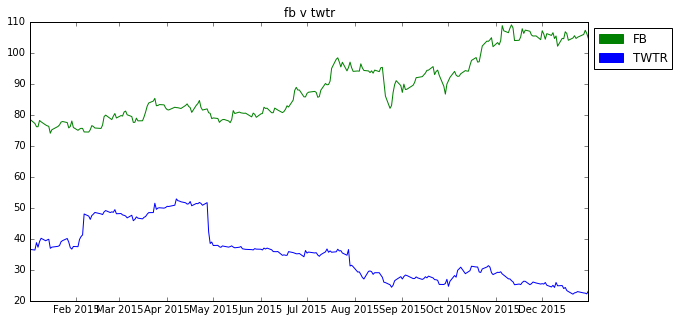

In [42]:
plt.figure(figsize=(10,5))
plt.plot(df1['Close'])
plt.plot(df2['Close'])
plt.title("fb v twtr")
az`
plt.show()

## 3.Understand the correlation

In [43]:
x = np.array(df1['Close'])
y = np.array(df2['Close'])
z = np.array(dfb['Close'])
print 'Correlation of TWTR to FB: ' + str(np.corrcoef(x, y)[0, 1])

Correlation of TWTR to FB: -0.739879974988


In [44]:
print 'Covariance of TWTR to FB: ' + str(np.cov(x, y)[0, 1])

Covariance of TWTR to FB: -66.2307989032


In [45]:
print 'Correlation of TWTR to FB: ' + str(np.corrcoef(x, y)[0, 1])

Correlation of TWTR to FB: -0.739879974988


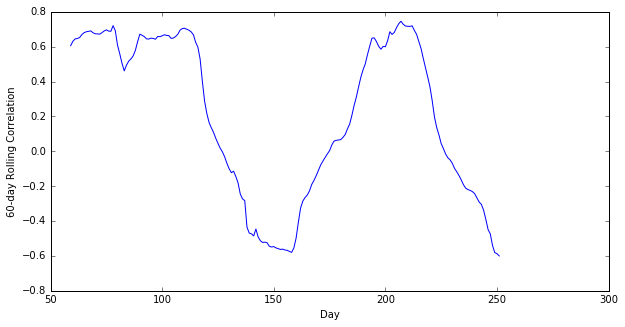

In [46]:
rolling_correlation = pd.rolling_corr(x, y, 60)
plt.figure(figsize=(10,5))
plt.plot(rolling_correlation)
plt.xlabel('Day')
plt.ylabel('60-day Rolling Correlation')

## 4.Using FB to predict TWTR

In [47]:
# First, run a linear regression on the two assets
slr = regression.linear_model.OLS(df1.Close, sm.add_constant(df2.Close)).fit()
print 'SLR beta of asset2:', slr.params[1]

SLR beta of asset2: -0.635163956174


## 5.Using FB + S&P500 to predict TWTR

In [48]:
# Run multiple linear regression using asset2 and SPY as independent variables
mlr = regression.linear_model.OLS(x, sm.add_constant(np.column_stack((y,z)))).fit()

prediction = mlr.params[0] + mlr.params[1]*df2.Close + mlr.params[2]*dfb.Close
prediction.name = 'Prediction'

print 'MLR beta of asset2:', mlr.params[1], '\nMLR beta of S&P 500:', mlr.params[2]

MLR beta of asset2: -0.610660235903 
MLR beta of S&P 500: 0.581079848726


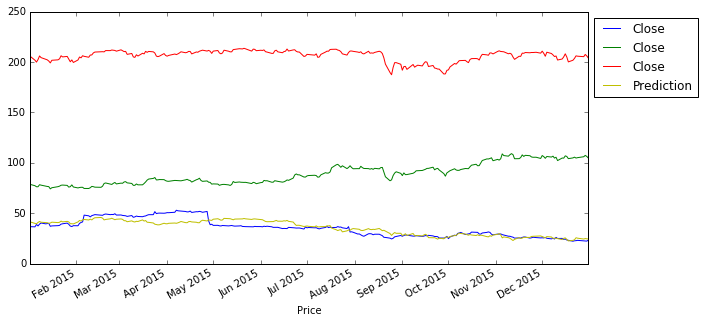

In [49]:
plt.figure(figsize=(10,5))
df1['Close'].plot()
df2['Close'].plot()
dfb['Close'].plot()
prediction.plot(color='y')
plt.xlabel('Price')
plt.legend(bbox_to_anchor=(1,1), loc=2);

# Maximum Likelihood

MLE IS JUST THE HIGHEST POINT ON A DISTRIBUTION CURVE

In [50]:
TRUE_MEAN = 40
TRUE_STD = 10
X = np.random.normal(TRUE_MEAN, TRUE_STD, 1000)

In [51]:
def normal_mu_MLE(X):
    # Get the number of observations
    T = len(X)
    # Sum the observations
    s = sum(X)
    return 1.0/T * s

def normal_sigma_MLE(X):
    T = len(X)
    # Get the mu MLE
    mu = normal_mu_MLE(X)
    # Sum the square of the differences
    s = sum( np.power((X - mu), 2) )
    # Compute sigma^2
    sigma_squared = 1.0/T * s
    return math.sqrt(sigma_squared)

In [52]:
print "Mean Estimation"
print normal_mu_MLE(X)
print np.mean(X)
print "Standard Deviation Estimation"
print normal_sigma_MLE(X)
print np.std(X)

Mean Estimation
39.9646392902
39.9646392902
Standard Deviation Estimation
9.76197372849
9.76197372849


## Get the MLE for TWTR

In [53]:
df1.head(1)

,Adj_Close,Close,High,Low,Open,Symbol,Volume
Date,,,,,,,
2015-01-02,36.560001,36.560001,36.740002,35.540001,36.23,TWTR,12062500


In [54]:
absolute_returns = np.diff(df1.Close)

In [55]:
returns = absolute_returns/x[:-1]

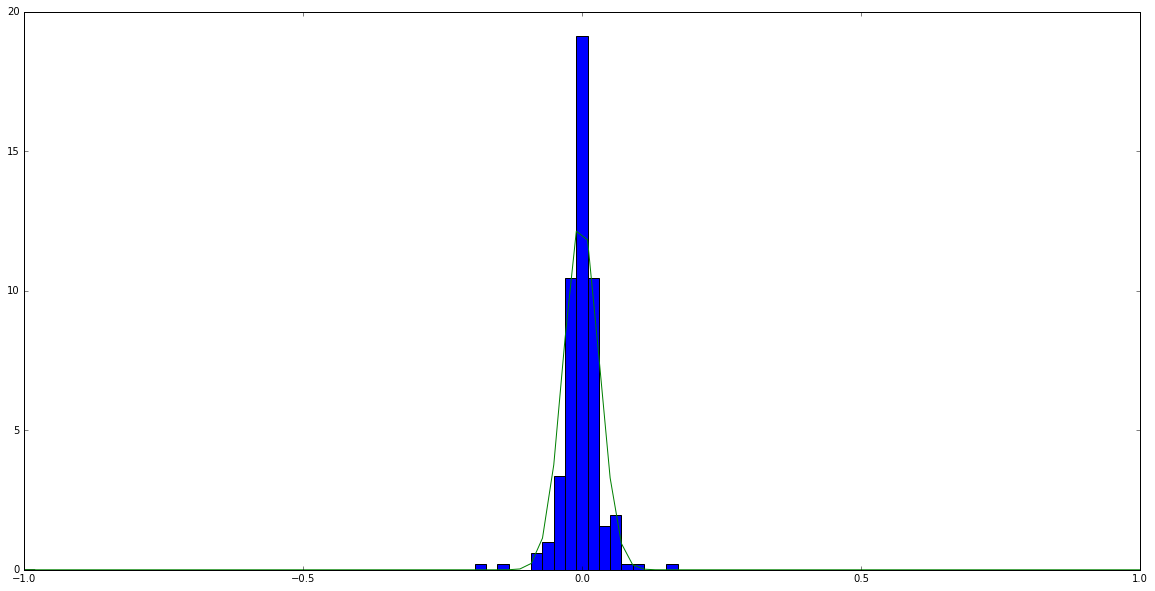

In [56]:
mu, std = scipy.stats.norm.fit(returns)
pdf = scipy.stats.norm.pdf
plt.figure(figsize=(20,10))
x = np.linspace(-1,1, num=100)
h = plt.hist(returns, bins=x, normed='true')
l = plt.plot(x, pdf(x, loc=mu, scale=std))

# Okay lets Beta Hedge

<img src="http://img-aws.ehowcdn.com/600x600p/photos.demandstudios.com/getty/article/178/63/87837318.jpg", width=300, height=800>

In [85]:
df1['twt'] = df1['Close']
dfb['s&p'] = dfb['Close']
r_a = df1.twt.pct_change()[1:]
r_b = dfb['s&p'].pct_change()[1:]

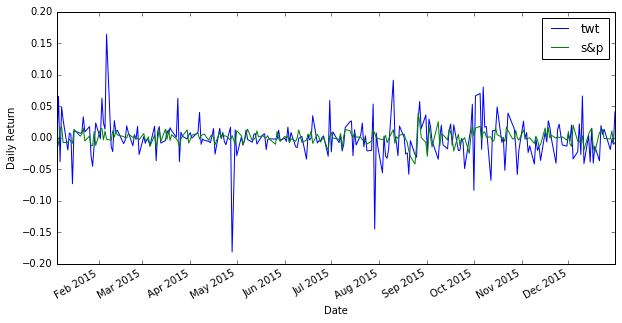

In [58]:
plt.figure(figsize=(10,5))
r_a.plot()
r_b.plot()
plt.ylabel("Daily Return")
plt.legend();

In [86]:
# Let's define everything in familiar regression terms
X = r_b.values # Get just the values, ignore the timestamps
Y = r_a.values

def linreg(x,y):
    # We add a constant so that we can also fit an intercept (alpha) to the model
    # This just adds a column of 1s to our data
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    # Remove the constant now that we're done
    x = x[:, 1]
    return model.params[0], model.params[1]

alpha1, beta2 = linreg(X,Y)
print 'alpha: ' + str(alpha1)
print 'beta: ' + str(beta2)

alpha: -0.00132725784628
beta: 0.818262218288


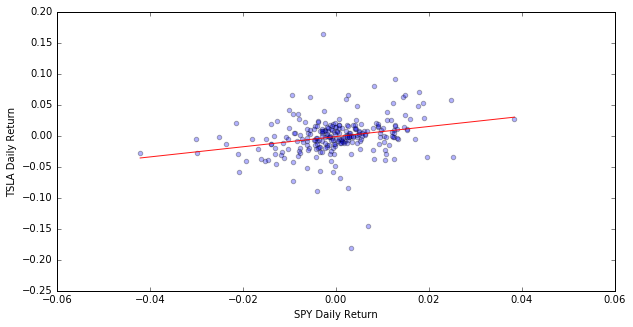

In [66]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta2 + alpha1
plt.figure(figsize=(10,5))
plt.scatter(X, Y, alpha=0.3) # Plot the raw data
plt.xlabel("SPY Daily Return")
plt.ylabel("TSLA Daily Return")

 # Add the regression line, colored in red
plt.plot(X2, Y_hat, 'r', alpha=0.9);

# Let's Hedge

<img src="http://www.forexrobottrader.com/images/headers/robots/has_mtf_hedge_robot-forex-robot.png", width=600, height=300>

with a Beta of 0.818 our strategy is exposed to market risk

In [67]:
beta2

0.81826221828801415

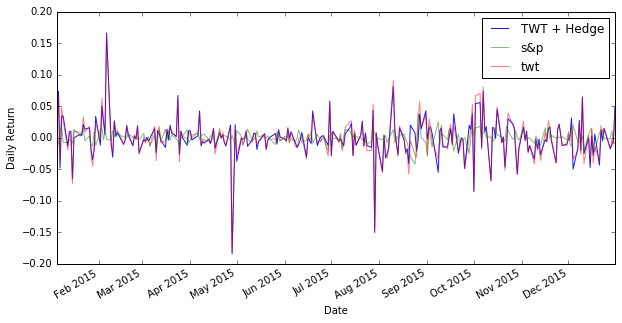

In [68]:
# Construct a portfolio with beta hedging
portfolio = -1*beta2*r_b + r_a
portfolio.name = "TWT + Hedge"

# Plot the returns of the portfolio as well as the asset by itself
plt.figure(figsize=(10,5))
portfolio.plot(alpha=0.9)
r_b.plot(alpha=0.5);
r_a.plot(alpha=0.5);
plt.ylabel("Daily Return")
plt.legend();

In [69]:
print "means: ", portfolio.mean(), r_a.mean()
print "volatilities: ", portfolio.std(), r_a.std()

means:  -0.00132725784628 -0.0013126392665
volatilities:  0.030649241194 0.0316875744509


In [70]:
P = portfolio.values
alpha, beta = linreg(X,P)
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)

alpha: -0.00132725784628
beta: -2.49800180541e-16


So we have eliminated out Beta (exposure to market risk) and have maintained our alpha

In [71]:
# Test our Strategy on an alternative time-period

In [87]:
asset1 = Share('TWTR')

benchmark = Share('SPY')
start = '2016-01-02'
end = '2016-04-30'

In [88]:
ass1 = asset1.get_historical(start, end)
ben = benchmark.get_historical(start, end)
df1 = pd.DataFrame(ass1).sort_values('Date')

dfb = pd.DataFrame(ben).sort_values('Date')
df1['Close'] = df1['Close'].astype('float64')

dfb['Close'] = dfb['Close'].astype('float64')
df1['Date'] = pd.to_datetime(df1['Date'])

dfb['Date'] = pd.to_datetime(dfb['Date'])
df1=df1.set_index('Date')

dfb=dfb.set_index('Date')
df1['twt'] = df1['Close']
dfb['s&p'] = dfb['Close']
r_a = df1.twt.pct_change()[1:]
r_b = dfb['s&p'].pct_change()[1:]

In [89]:
print 'Asset Historical Estimate:'
print 'alpha: ' + str(alpha1)
print 'beta: ' + str(beta2)

Asset Historical Estimate:
alpha: -0.00132725784628
beta: 0.818262218288


Asset Historical Estimate:
alpha: -0.00132725784628
beta: 0.818262218288
Asset Out of Sample Estimate:
alpha: -0.00514987974369
beta: 1.64012252605
Portfolio Out of Sample:
alpha: -0.00514987974369
beta: 0.821860307758


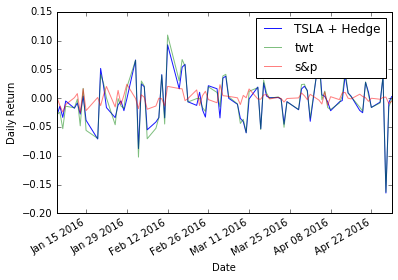

In [90]:
print 'Asset Historical Estimate:'
print 'alpha: ' + str(alpha1)
print 'beta: ' + str(beta2)

X = r_b.values
Y = r_a.values
alpha, beta = linreg(X,Y)
print 'Asset Out of Sample Estimate:'
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)

# Create hedged portfolio and compute alpha and beta
portfolio = -1*beta2*r_b + r_a
P = portfolio.values
alpha, beta = linreg(X,P)
print 'Portfolio Out of Sample:'
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)


# Plot the returns of the portfolio as well as the asset by itself
portfolio.name = "TSLA + Hedge"
portfolio.plot(alpha=0.9)
r_a.plot(alpha=0.5);
r_b.plot(alpha=0.5)
plt.ylabel("Daily Return")
plt.legend();

# Markov Chains

In [2]:
from quantecon import DiscreteRV

In [5]:
psi = (0.1, 0.9)           # Probabilities over sample space {0, 1}

d = DiscreteRV(psi)

d.draw(5)            

array([1, 1, 1, 1, 1])

In [6]:
import numpy as np
import quantecon as qe

def mc_sample_path(P, init=0, sample_size=1000):
    # === make sure P is a NumPy array === #
    P = np.asarray(P)
    # === allocate memory === #
    X = np.empty(sample_size, dtype=int)
    X[0] = init
    # === convert each row of P into a distribution === #
    # In particular, P_dist[i] = the distribution corresponding to P[i,:]
    n = len(P)
    P_dist = [qe.DiscreteRV(P[i,:]) for i in range(n)]

    # === generate the sample path === #
    for t in range(sample_size - 1):
        X[t+1] = P_dist[X[t]].draw()

    return X

In [7]:
P = [[0.4, 0.6], [0.2, 0.8]]

In [8]:
X = mc_sample_path(P, sample_size=100000)

np.mean(X == 0)

0.25185999999999997